In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

In [2]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [3]:
hoep_data = pd.read_csv('clean_hoep_on_comb_a1.csv')
test_data = pd.read_csv('test_Jul19.csv')
train_data = pd.read_csv('train_2016-2019.csv')
validation_data = pd.read_csv('validation_aug19.csv')

In [4]:
hoep_data.head(5)

,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station
0,2016-01-01,Friday,0,0.49,14023,-0.3,-5.62,20,-3.18,70,-5.1,99.67
1,2016-01-01,Friday,1,-1.09,13417,-0.3,-6.30,25,-3.48,68,-5.5,99.63
2,2016-01-01,Friday,2,-2.41,12968,-0.4,-6.55,26,-3.43,73,-4.7,99.59
3,2016-01-01,Friday,12,0.00,14215,-2.1,-8.72,23,-4.86,76,-5.8,99.39
4,2016-01-01,Friday,13,0.00,14443,-2.4,-8.23,19,-5.09,84,-4.7,99.35


# Function

In [19]:
def eda(data):
    print("-----------Information-----------")
    print(data.info())
    print("-----------Data Types-----------")
    print(data.dtypes)
    print("----------Missing value-----------")
    print(data.isnull().sum())
    print("----------Null value-----------")
    print(data.isna().sum())
    print("----------Shape of Data----------")
    print(data.shape)

def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);
    
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True) #subset is list where you have to put all column for duplicate check
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)

# 1. Check All Data Exploration Analysis

1. HOEP Train Data
2. HOEP Test Data 
3. HOEP Validation Data
4. HOEP Data (2016-2020)

-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26627 entries, 0 to 26626
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26627 non-null  int64  
 1   Date               26627 non-null  object 
 2   Weekday            26627 non-null  object 
 3   Hour               26627 non-null  int64  
 4   HOEP               26627 non-null  float64
 5   Ontario_Demand     26627 non-null  int64  
 6   Temperature        26627 non-null  float64
 7   Windchill_Index    26627 non-null  float64
 8   Wind_Speed         26627 non-null  int64  
 9   Humidex            26627 non-null  float64
 10  Relative_Humidity  26627 non-null  int64  
 11  Dew_Point          26627 non-null  float64
 12  Pressure_Station   26627 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 2.6+ MB
None
-----------Data Types-----------
Unnamed: 0             int64
Date    

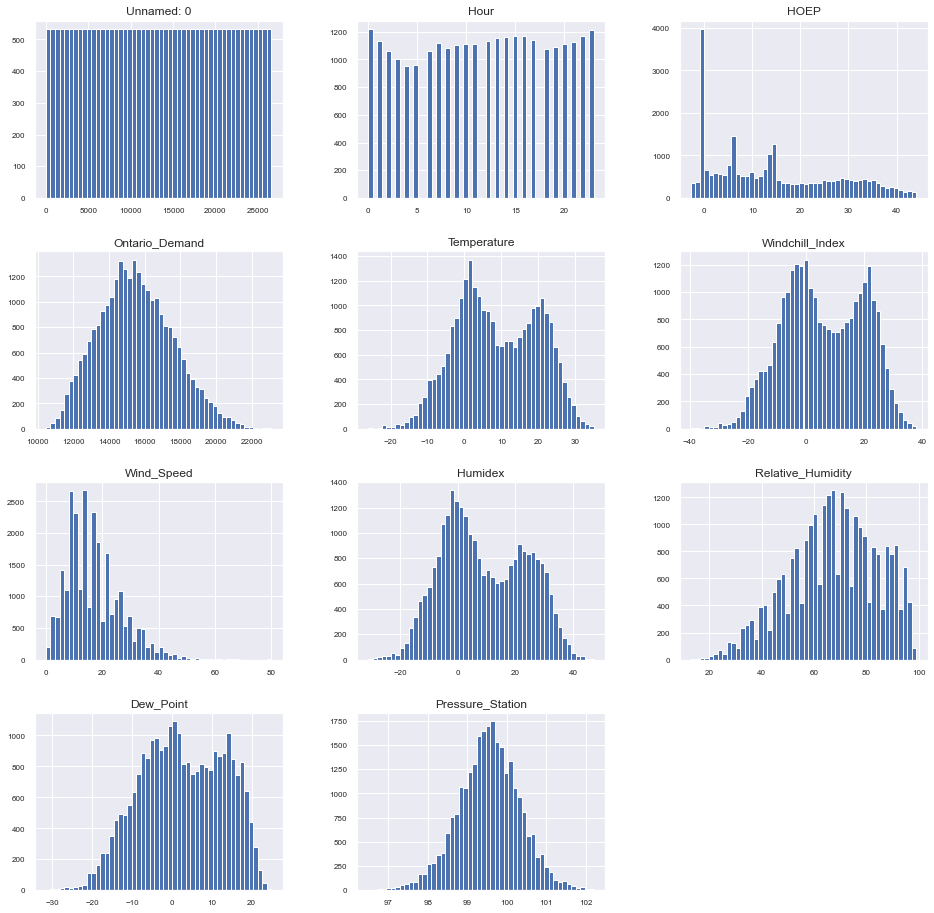

In [20]:
eda(train_data)
graph_insight(train_data)

-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         701 non-null    int64  
 1   Date               701 non-null    object 
 2   Weekday            701 non-null    object 
 3   Hour               701 non-null    int64  
 4   HOEP               701 non-null    float64
 5   Ontario_Demand     701 non-null    int64  
 6   Temperature        701 non-null    float64
 7   Windchill_Index    701 non-null    float64
 8   Wind_Speed         701 non-null    int64  
 9   Humidex            701 non-null    float64
 10  Relative_Humidity  701 non-null    int64  
 11  Dew_Point          701 non-null    float64
 12  Pressure_Station   701 non-null    float64
dtypes: float64(6), int64(5), object(2)
memory usage: 71.3+ KB
None
-----------Data Types-----------
Unnamed: 0             int64
Date       

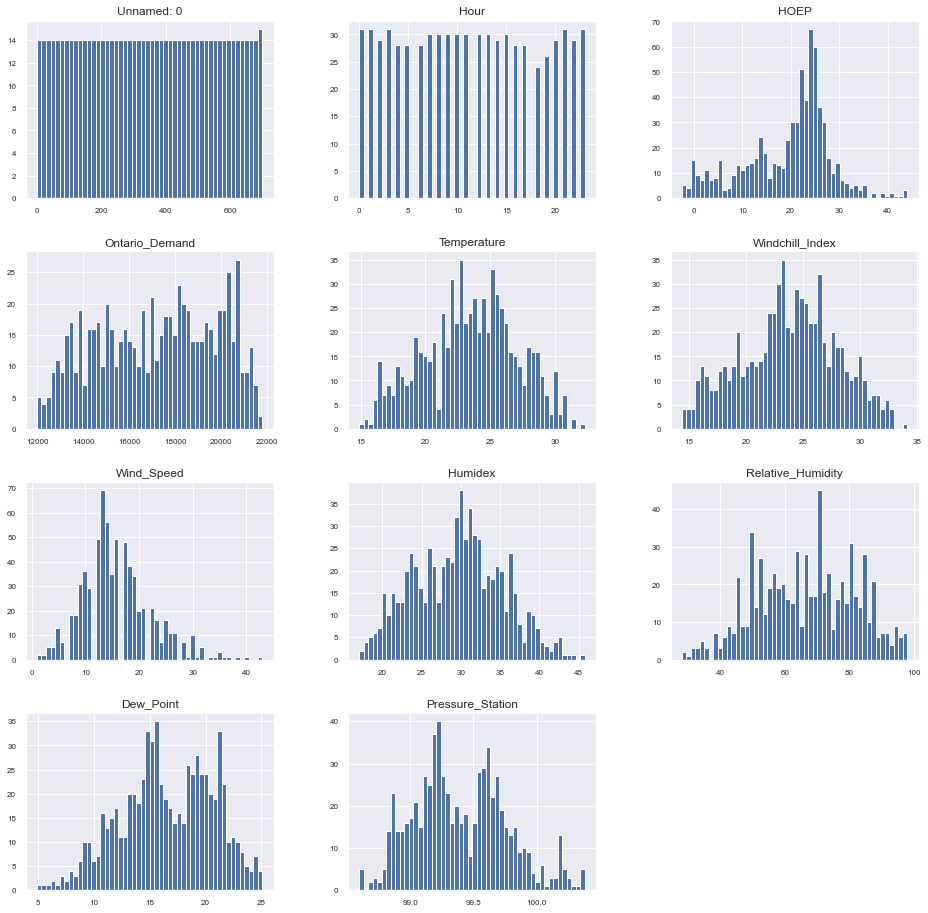

In [21]:
eda(test_data)
graph_insight(test_data)

-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         701 non-null    int64  
 1   Date               701 non-null    object 
 2   Weekday            701 non-null    object 
 3   Hour               701 non-null    int64  
 4   HOEP               701 non-null    float64
 5   Ontario_Demand     701 non-null    int64  
 6   Temperature        701 non-null    float64
 7   Windchill_Index    701 non-null    float64
 8   Wind_Speed         701 non-null    int64  
 9   Humidex            701 non-null    float64
 10  Relative_Humidity  701 non-null    int64  
 11  Dew_Point          701 non-null    float64
 12  Pressure_Station   701 non-null    float64
dtypes: float64(6), int64(5), object(2)
memory usage: 71.3+ KB
None
-----------Data Types-----------
Unnamed: 0             int64
Date       

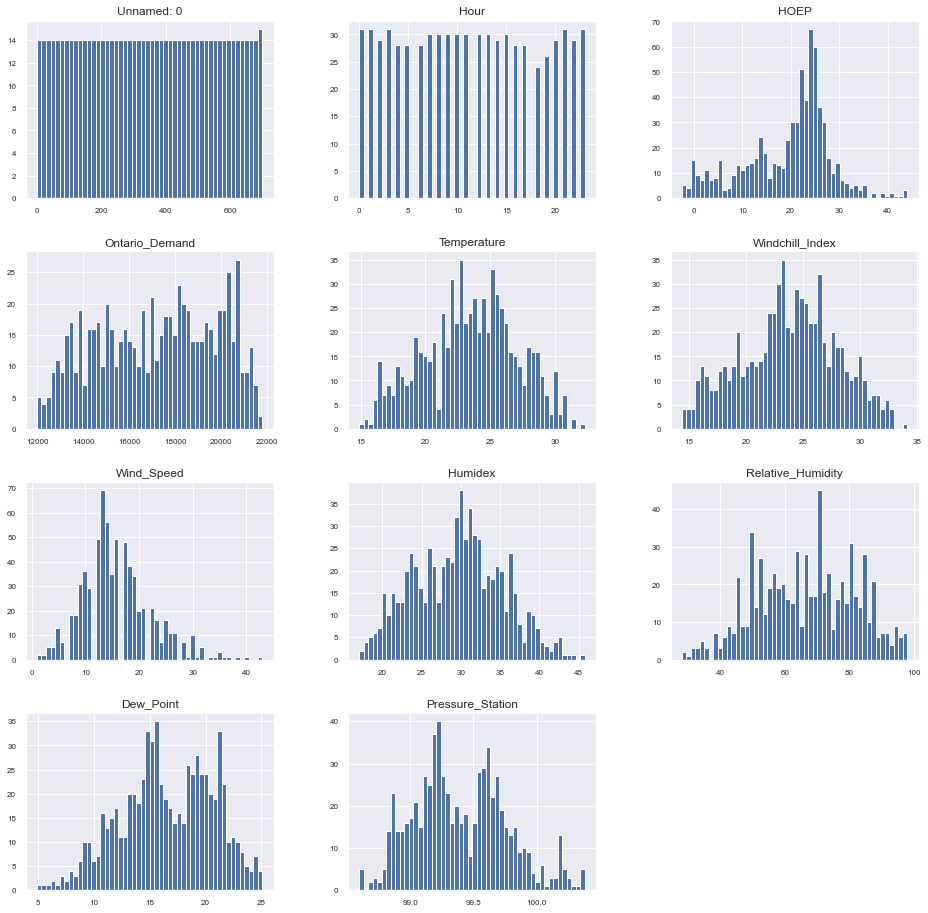

In [22]:
eda(validation_data)
graph_insight(validation_data)

We have to change the type of some of the columns, so that all of them are float64. We also have to parse 'dt_iso' correctly and actually rename it as 'time' so that it matches with the index of df_energy.

In [9]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/Users/jadenkim/opt/anaconda3/envs/test1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


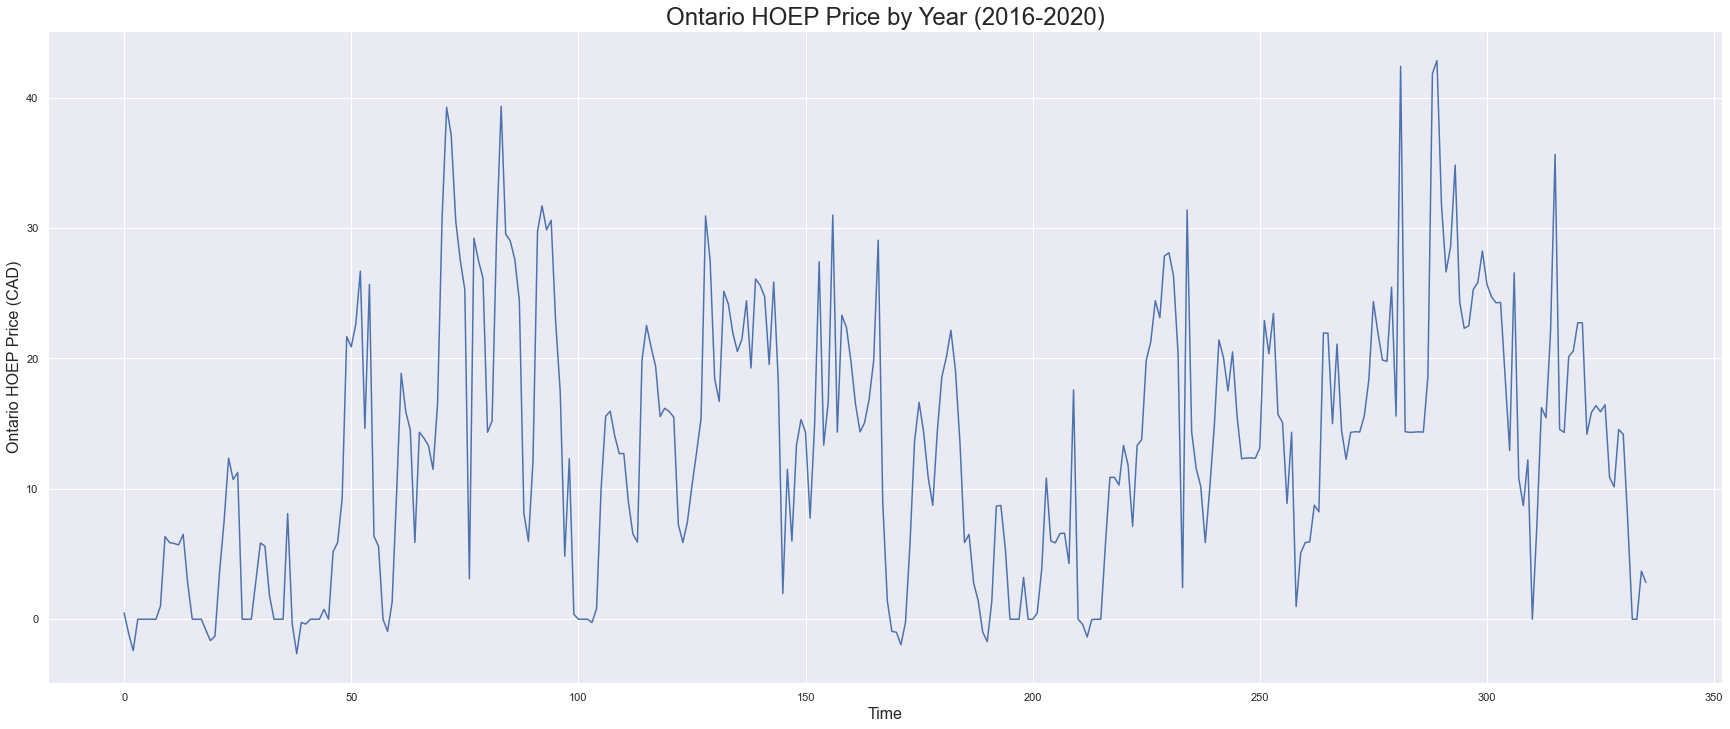

In [18]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=hoep_data, column='HOEP', ylabel='Ontario HOEP Price (CAD)',
                 title='Ontario HOEP Price by Year (2016-2020)', end=24*7*2)
plt.show()

Before proceeding to the next step, i.e. merging df_energy and df_weather, we also want to treat the outliers which we found earlier in 'pressure' and 'wind_speed'. We will visualize the outliers in these columns using boxplot, change their values to NaNs and then use a linear interpolation in order to replace their values.

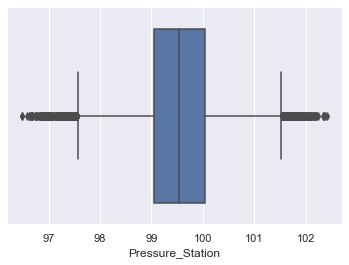

In [23]:
# Check for outliers in 'pressure' column

sns.boxplot(x=hoep_data['Pressure_Station'])
plt.show()

Things look a lot better regarding atmospheric pressure ('pressure') as the column has been cleaned of extreme-case outliers. What about 'wind_speed' however?

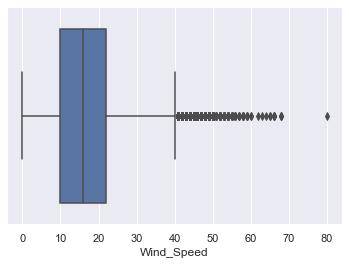

In [24]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=hoep_data['Wind_Speed'])
plt.show()

# 2. Visualizations and Time Series Analysis

# 2.1. Useful visualizations and insights

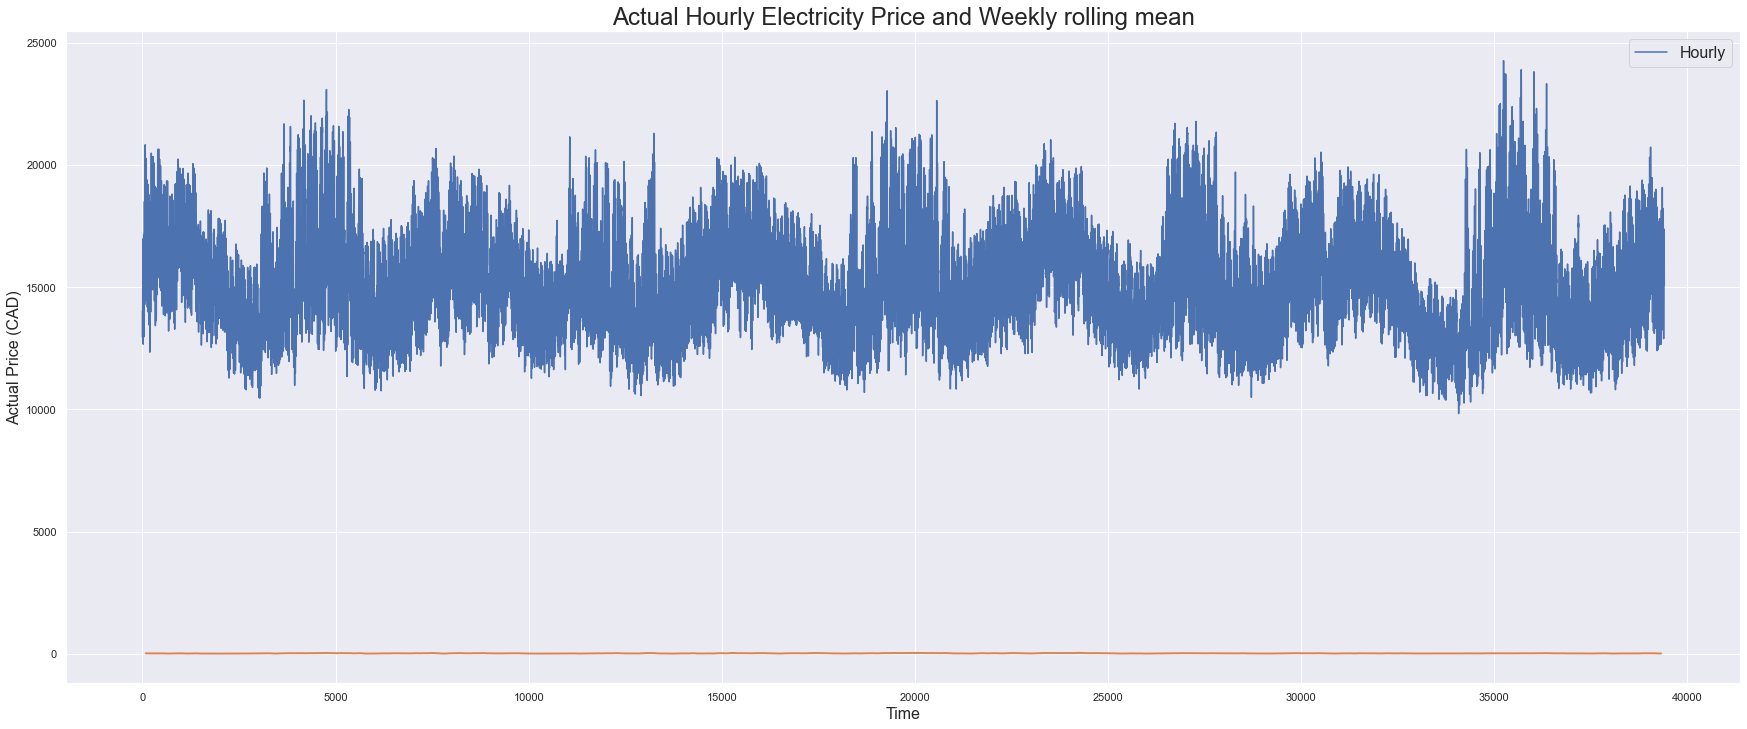

In [30]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = hoep_data['HOEP'].rolling(24*7, center=True).mean()
ax = plot_series(hoep_data, 'Ontario_Demand', label='Hourly', ylabel='Actual Price (CAD)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

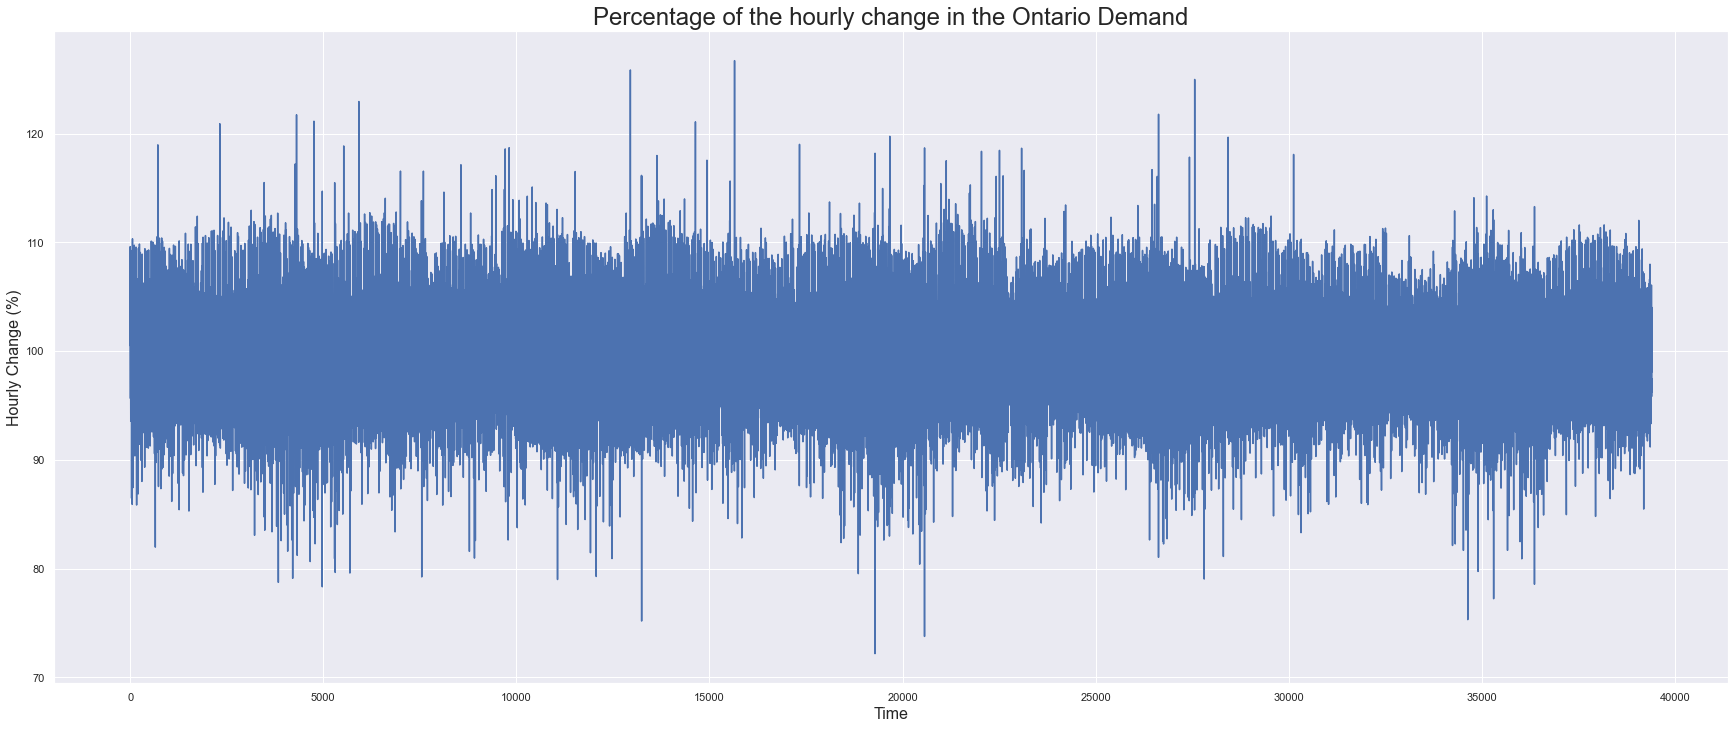

In [38]:
# Plot the percentage of the hourly change in the Ontario Demand

change = hoep_data['Ontario_Demand'].div(hoep_data['Ontario_Demand'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the Ontario Demand')
plt.show()

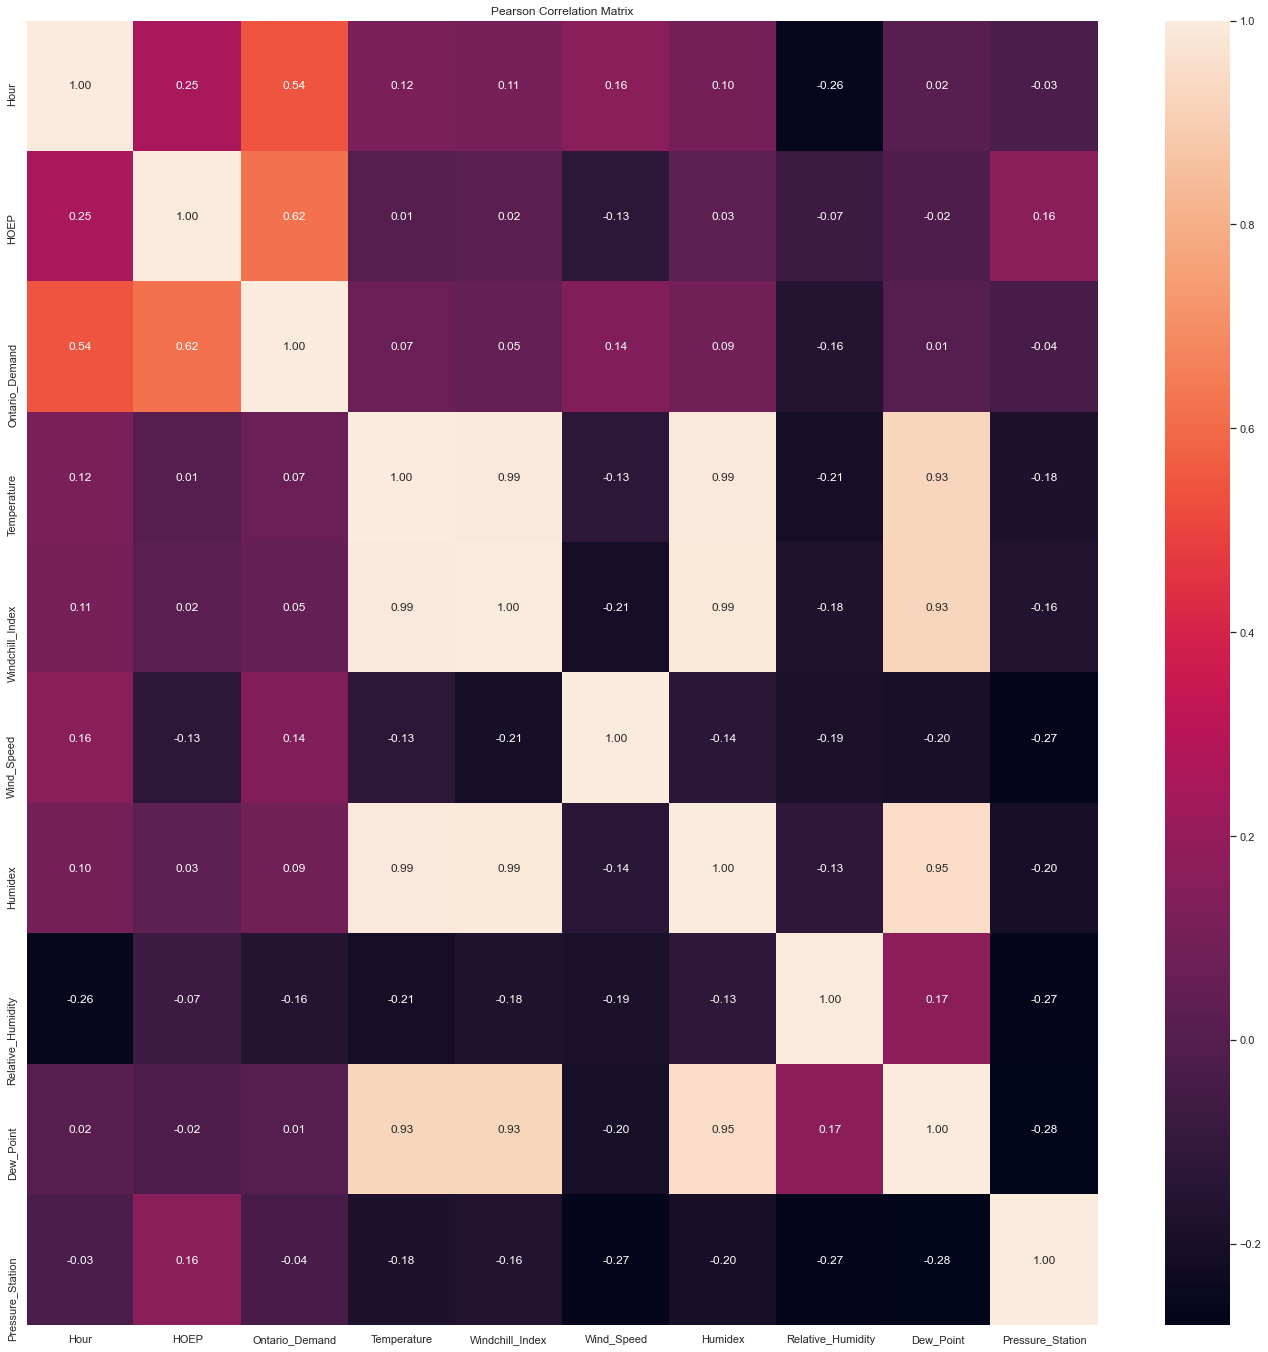

In [42]:
# Plot Pearson correlation matrix

correlations = hoep_data.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [47]:
highly_correlated = abs(correlations[correlations > 0.60])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

HOEP             Ontario_Demand     0.615273
Ontario_Demand   HOEP               0.615273
Temperature      Windchill_Index    0.993878
                 Humidex            0.991548
                 Dew_Point          0.926284
Windchill_Index  Temperature        0.993878
                 Humidex            0.987675
                 Dew_Point          0.929150
Humidex          Temperature        0.991548
                 Windchill_Index    0.987675
                 Dew_Point          0.950906
Dew_Point        Temperature        0.926284
                 Windchill_Index    0.929150
                 Humidex            0.950906


What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).

# 3. Feature Engineering

# 3.1. Feature generation

The first features that we will generate for a given hour will just be that particular hour, the day and the month in which it falls into.

In [48]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(hoep_data)):
    position = hoep_data.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    hoep_data.loc[position, 'hour'] = hour
    hoep_data.loc[position, 'weekday'] = weekday
    hoep_data.loc[position, 'month'] = month

AttributeError: 'int' object has no attribute 'hour'

A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity in Canada (Ontario) as the 9AM-5PM working day is not generally followed by all types of businesses. The most usual business hours are from Monday-Friday (or even Saturday).

Therefore, the value of the 'business hour' will be equal to '2' if the given hour is within the business hours, equal to '1' if the given hour is within the "siesta" in between and equal to '0' for all other given hours.

In [50]:
# Generate 'business hour' feature

for i in range(len(hoep_data)):
    position = hoep_data.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        hoep_data.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        hoep_data.loc[position, 'business hour'] = 1
    else:
        hoep_data.loc[position, 'business hour'] = 0

AttributeError: 'int' object has no attribute 'hour'

In [ ]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

# 4. Electricity Price Forecasting

In [ ]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()


# 4.2. XGBoost

In [ ]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [ ]:
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

In [ ]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))